In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

EXECUTION_START_TIME = time.time() # 計算執行時間

In [2]:
df = pd.read_csv('google_review_ratings.csv') 
df.info()
print(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5456 entries, 0 to 5455
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   User         5456 non-null   object 
 1   Category 1   5456 non-null   float64
 2   Category 2   5456 non-null   float64
 3   Category 3   5456 non-null   float64
 4   Category 4   5456 non-null   float64
 5   Category 5   5456 non-null   float64
 6   Category 6   5456 non-null   float64
 7   Category 7   5456 non-null   float64
 8   Category 8   5456 non-null   float64
 9   Category 9   5456 non-null   float64
 10  Category 10  5456 non-null   float64
 11  Category 11  5456 non-null   object 
 12  Category 12  5455 non-null   float64
 13  Category 13  5456 non-null   float64
 14  Category 14  5456 non-null   float64
 15  Category 15  5456 non-null   float64
 16  Category 16  5456 non-null   float64
 17  Category 17  5456 non-null   float64
 18  Category 18  5456 non-null   float64
 19  Catego

## dataset description
- user 欄位為沒有意義的流水號
- category11 的 type 不知為何是 object, 將其轉為 float
- category25 幾乎沒有資料, 因此將其移除
- category12, 24 有缺值, 將其以中位數補上

### question :
**" Google user rating ranges from 1 to 5 and average user rating per category is calculated."**

根據網站描述, 可以理解為每個數值是'該使用者到過的所有該類別地點的評分平均'

且根據描述, 應該不能評一分以下的分數

因此即使將 0 分的視為該使用者沒有作任何評分

也無法解釋介於 0 ~ 1 分是如何產出的
### solution :
- 無視 0 ~ 1 的值
- 將值為 0 的視為缺失值, 並以 knn 補上

In [3]:
train = df[['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5', 'Category 6',
           'Category 7', 'Category 8', 'Category 9', 'Category 10', 'Category 11', 'Category 12',
           'Category 13', 'Category 14', 'Category 15', 'Category 16', 'Category 17', 'Category 18',
           'Category 19', 'Category 20', 'Category 21', 'Category 22', 'Category 23', 'Category 24']]  

# 填補缺失值 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
c12 = train['Category 12'].to_numpy().reshape(-1, 1)
imputer.fit(c12)
train['Category 12'] = imputer.transform(c12)
c24 = train['Category 24'].to_numpy().reshape(-1, 1)
imputer.fit(c24)
train['Category 24'] = imputer.transform(c24)


# convert category 11 into float
train['Category 11'] = pd.to_numeric(train['Category 11'],errors='coerce')


# replace 0 value
np.random.seed(0)
from sklearn.impute import KNNImputer
train_arr = train.to_numpy().reshape(-1, 24)
for i in range(len(train_arr)):
    for j in range(len(train_arr[0])):
        if train_arr[i][j] == 0:
            #train_arr[i][j] = np.nan
            pass
k_imputer = KNNImputer()
k_imputer.fit(train_arr)
train_arr = k_imputer.transform(train_arr)

print(train_arr)

[[0.   0.   3.63 ... 0.   0.   0.  ]
 [0.   0.   3.63 ... 0.   0.   0.  ]
 [0.   0.   3.63 ... 0.   0.   0.  ]
 ...
 [0.94 5.   4.03 ... 5.   5.   1.11]
 [0.95 4.05 4.05 ... 5.   5.   1.12]
 [0.95 4.07 5.   ... 5.   5.   1.17]]


/home/sdcaramel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/sdcaramel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/sdcaramel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

## Problem decision
我在想分析目標時發現了幾個問題
- 各個類別間沒有因果關係
- 各個類別間沒有重要性差異（沒有預測單個類別的必要）
- 每個 user 對於不同類型的喜好差異極大
- 種類過多導致分群困難

因此我打算先算出類別間彼此的相關性

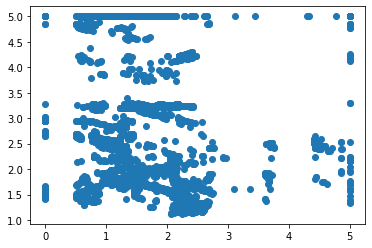

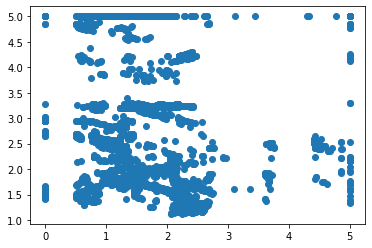

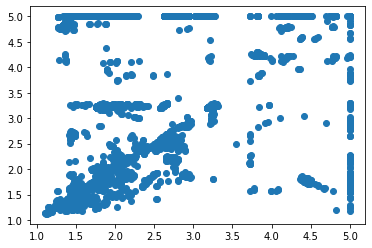

In [4]:
means = np.zeros(24)
std = np.zeros(24)
x = np.linspace(1, 24, 24)
cust = np.linspace(1, 5456, 5456)

for i in range(24):
    means[i] = np.mean(train_arr[:, i])
    
for i in range(24):
    std[i] = np.std(train_arr[:, i])
    
#plt.bar(x, means)
#plt.show()
#plt.bar(x, std)
#plt.show()
plt.scatter(train['Category 1'], train['Category 7'])
plt.show()
plt.scatter(train_arr[:,0], train_arr[:,6])
plt.show()
plt.scatter(train_arr[:,5], train_arr[:,6])
plt.show()

## 問題發現
我在上面試著將不同 category 繪成 scatter plot

發現有非常多值在 x = 5 or y = 5 的線上

由於數量繁多, 不確定將其全部視為 outlier 會不會影響結果

因此打算測試多組, 一組有沒有移除, 其他的以不同方式移除

In [5]:
import copy
train_rm = copy.copy(train)

In [6]:
# use knn
train_arr_rm = train_rm.to_numpy().reshape(-1, 24)
for i in range(len(train_arr_rm)):
    for j in range(len(train_arr_rm[0])):
        if train_arr_rm[i][j] == 5:
            train_arr_rm[i][j] = np.nan
k_imputer = KNNImputer()
k_imputer.fit(train_arr_rm)
train_arr_rm = k_imputer.transform(train_arr_rm)

train_rm['Category 1'] = train_arr_rm[:, 0]
train_rm['Category 2'] = train_arr_rm[:, 1]
train_rm['Category 3'] = train_arr_rm[:, 2]
train_rm['Category 4'] = train_arr_rm[:, 3]
train_rm['Category 5'] = train_arr_rm[:, 4]
train_rm['Category 6'] = train_arr_rm[:, 5]
train_rm['Category 7'] = train_arr_rm[:, 6]
train_rm['Category 8'] = train_arr_rm[:, 7]
train_rm['Category 9'] = train_arr_rm[:, 8]
train_rm['Category 10'] = train_arr_rm[:, 9]
train_rm['Category 11'] = train_arr_rm[:, 10]
train_rm['Category 12'] = train_arr_rm[:, 11]
train_rm['Category 13'] = train_arr_rm[:, 12]
train_rm['Category 14'] = train_arr_rm[:, 13]
train_rm['Category 15'] = train_arr_rm[:, 14]
train_rm['Category 16'] = train_arr_rm[:, 15]
train_rm['Category 17'] = train_arr_rm[:, 16]
train_rm['Category 18'] = train_arr_rm[:, 17]
train_rm['Category 19'] = train_arr_rm[:, 18]
train_rm['Category 20'] = train_arr_rm[:, 19]
train_rm['Category 21'] = train_arr_rm[:, 20]
train_rm['Category 22'] = train_arr_rm[:, 21]
train_rm['Category 23'] = train_arr_rm[:, 22]
train_rm['Category 24'] = train_arr_rm[:, 23]



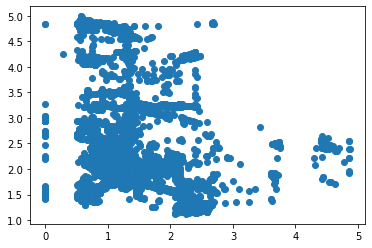

In [7]:
plt.scatter(train_arr_rm[:,0], train_arr_rm[:,6])
plt.show()

,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10,...,Category 15,Category 16,Category 17,Category 18,Category 19,Category 20,Category 21,Category 22,Category 23,Category 24
Category 1,1.000000,0.549477,0.290278,0.084474,0.040741,-0.028463,-0.177155,-0.234396,-0.251363,-0.292503,...,-0.048640,0.086663,0.169104,0.249545,0.235643,0.249574,0.400916,0.472025,0.551680,0.666919
Category 2,0.549477,1.000000,0.539818,0.178197,0.064167,-0.011415,-0.147862,-0.265666,-0.229488,-0.304142,...,-0.041629,0.081371,0.135900,0.184867,0.152578,0.161333,0.270984,0.257603,0.354648,0.426933
Category 3,0.290278,0.539818,1.000000,0.491517,0.205214,0.046331,-0.200048,-0.261292,-0.255059,-0.299548,...,-0.083244,-0.023752,-0.003784,0.073361,0.051781,0.057829,0.154438,0.165821,0.187804,0.198902
Category 4,0.084474,0.178197,0.491517,1.000000,0.673200,0.397219,-0.215450,-0.145281,-0.216793,-0.162234,...,0.054307,0.088131,-0.174430,-0.222021,-0.236524,-0.116794,-0.094221,0.038843,0.017686,0.027466
Category 5,0.040741,0.064167,0.205214,0.673200,1.000000,0.671027,0.033982,-0.008744,-0.082547,-0.094064,...,0.007220,0.010781,-0.199707,-0.315781,-0.319145,-0.210866,-0.164316,0.036394,-0.029047,-0.020524
Category 6,-0.028463,-0.011415,0.046331,0.397219,0.671027,1.000000,0.279644,0.198519,0.047624,-0.071940,...,-0.040970,0.008432,-0.180935,-0.270691,-0.271544,-0.207217,-0.253146,0.017094,-0.111349,-0.089098
Category 7,-0.177155,-0.147862,-0.200048,-0.215450,0.033982,0.279644,1.000000,0.658693,0.380692,0.247234,...,-0.048614,-0.194561,-0.178572,-0.189840,-0.181085,-0.176572,-0.244245,-0.210193,-0.235997,-0.210285
Category 8,-0.234396,-0.265666,-0.261292,-0.145281,-0.008744,0.198519,0.658693,1.000000,0.581994,0.451006,...,-0.019084,-0.092260,-0.219355,-0.285732,-0.301302,-0.244407,-0.312246,-0.223597,-0.252424,-0.217082
Category 9,-0.251363,-0.229488,-0.255059,-0.216793,-0.082547,0.047624,0.380692,0.581994,1.000000,0.640548,...,0.091669,-0.007113,-0.138620,-0.244657,-0.275907,-0.224745,-0.328055,-0.245166,-0.312204,-0.278628
Category 10,-0.292503,-0.304142,-0.299548,-0.162234,-0.094064,-0.071940,0.247234,0.451006,0.640548,1.000000,...,0.102966,0.063029,-0.114434,-0.223574,-0.284920,-0.198779,-0.371602,-0.219481,-0.323291,-0.283137


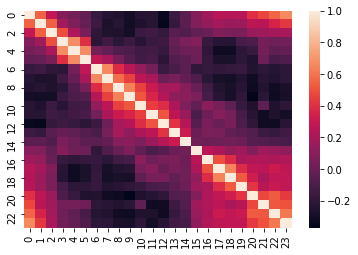

In [8]:
import seaborn

co = train_rm.corr()
co = co.to_numpy().reshape(24,24)

seaborn.heatmap(co)

train_rm.corr()

## Problem desicion version 2
從散佈圖和相關係數仍然看不出各 category 之間的關聯性，因此更改目標為將使用者分群

## 評估方法
1. 利用 k means 將母體分成 n 個子群
2. 計算每個子群的變異數
3. 重複測試不同的 n，找出變異數最小的 n

culster number : 2
culster number : 3
culster number : 4
culster number : 5
culster number : 6
culster number : 7
culster number : 8
culster number : 9
culster number : 10
culster number : 11
culster number : 12
culster number : 13
culster number : 14
culster number : 15
culster number : 16
culster number : 17
culster number : 18
culster number : 19
culster number : 20
culster number : 21
culster number : 22
culster number : 23
culster number : 24
culster number : 25
culster number : 26
culster number : 27
culster number : 28
culster number : 29
culster number : 30
culster number : 31
culster number : 32
culster number : 33
culster number : 34
culster number : 35
culster number : 36
culster number : 37
culster number : 38
culster number : 39
culster number : 40
culster number : 41
culster number : 42
culster number : 43
culster number : 44
culster number : 45
culster number : 46
culster number : 47
culster number : 48
culster number : 49
culster number : 50
culster number : 51
culster 

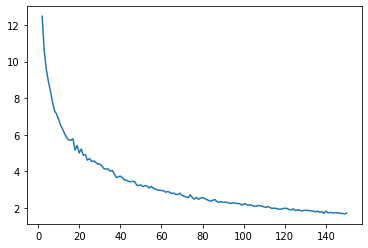

In [9]:
from sklearn import cluster

cluster_n = 2               # 起始群數
ending_n = 150              # 結束群數

var_x = []
plot_x = np.linspace(2, ending_n, ending_n - 1)
while True:
    model = cluster.KMeans(n_clusters=cluster_n)
    k_fit = model.fit(train_rm)

    cluster_list = []
    variance = []

    # 將不同群分組
    for i in range(cluster_n):
        l = train_arr_rm[k_fit.labels_ == i]
        cluster_list.append(l)
        v = 0
        # 計算群內變異數
        for j in range(24):
            v = v + np.var(cluster_list[i][:, j])
        variance.append(v)

    print('culster number : {}'.format(cluster_n))
    #print(variance)
    #print(np.mean(variance))
    #print()
    var_x.append(np.mean(variance))
    cluster_n = cluster_n + 1
    if (cluster_n > ending_n):
        break
        
plt.plot(plot_x, var_x)

## 觀察
從折線圖看來，隨著 n 的增加變異數大概會持續減少直到 0 為止

不過分的太細就失去了分群的意義，所以應該要嘗試找出一個折衷的數字

## PCA 主成份分析
用 pca 將資料降到 2 維看看有沒有明顯的分群

跟同學討論過後發現兩人降維後的資料長得不一樣

討論後認為是 preprocessing 的方式不一樣

在思考哪種方法比較適合的時候覺得原始資料有很多問題

1. 一開始就有發現的 0 ~ 1 分的評分
2. 多數使用者的評分很極端，常常是某些給到 5 分，有些卻只給 1 分
3. 將分佈圖畫出來後發現多數分數集中在 3 分以下，然而 google map 上多數店家的評分都在 4 分以上


- 結論：
因為資料集感覺本身就有一些問題，因此不打算糾結在 preprocessing 的對錯上

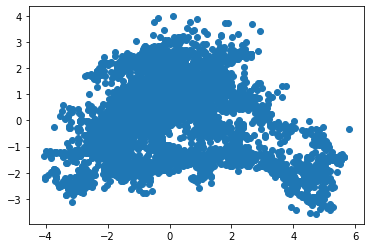

In [10]:
from sklearn.decomposition import PCA 
pca=PCA(n_components=2)
new_data = pca.fit_transform(train_rm)
plt.scatter(new_data[:, 0], new_data[:, 1])

## 最佳分群數目
根據 Elbow Method 的原理，"使群內的總變異最小；使群間的總變異最大"

接下來用跟上面類似的方式求群間變異數

In [11]:
cluster_n = 2
ending_n = 150

var_ex = []

while True:
    model = cluster.KMeans(n_clusters=cluster_n)
    k_fit = model.fit(train_rm)

    cluster_list = []
    # 將不同群分組
    for i in range(cluster_n):
        l = train_arr_rm[k_fit.labels_ == i]
        cluster_list.append(l)

    # 計算各群各 category 的平均
    cluster_mean = np.zeros(cluster_n * 24).reshape(-1, 24)
    for i in range(cluster_n):
        for j in range(24):
            cluster_mean[i][j] = np.mean(cluster_list[i][:,j])
            
    # 計算群間變異數
    v = 0
    for i in range(24):
        v = v + np.var(cluster_mean[:,i])
        

    print('culster number : {}'.format(cluster_n))
    #print(variance)
    #print(np.mean(variance))
    #print()
    var_ex.append(v)
    cluster_n = cluster_n + 1
    if (cluster_n > ending_n):
        break
        


culster number : 2
culster number : 3
culster number : 4
culster number : 5
culster number : 6
culster number : 7
culster number : 8
culster number : 9
culster number : 10
culster number : 11
culster number : 12
culster number : 13
culster number : 14
culster number : 15
culster number : 16
culster number : 17
culster number : 18
culster number : 19
culster number : 20
culster number : 21
culster number : 22
culster number : 23
culster number : 24
culster number : 25
culster number : 26
culster number : 27
culster number : 28
culster number : 29
culster number : 30
culster number : 31
culster number : 32
culster number : 33
culster number : 34
culster number : 35
culster number : 36
culster number : 37
culster number : 38
culster number : 39
culster number : 40
culster number : 41
culster number : 42
culster number : 43
culster number : 44
culster number : 45
culster number : 46
culster number : 47
culster number : 48
culster number : 49
culster number : 50
culster number : 51
culster 

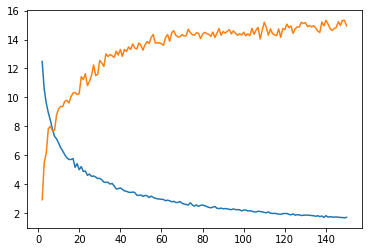

In [12]:
plot_ex = np.linspace(2, 50, 49)

plt.plot(plot_x, var_x)
plt.plot(plot_x, var_ex)



## 結果
群間變異數沒有變小的趨勢，因此嘗試別的方法

這次嘗試用 silhouette method

In [13]:
from sklearn.metrics import silhouette_score

cluster_n = 2
ending_n = 150

s_avg = []

while True:
    model = cluster.KMeans(n_clusters=cluster_n)
    k_fit = model.fit(train_rm)

    cluster_list = []
    # 將不同群分組
    for i in range(cluster_n):
        l = train_arr_rm[k_fit.labels_ == i]
        cluster_list.append(l)

    # 計算各群各 category 的平均
    cluster_mean = np.zeros(cluster_n * 24).reshape(-1, 24)
    for i in range(cluster_n):
        for j in range(24):
            cluster_mean[i][j] = np.mean(cluster_list[i][:,j])
            
    s_avg.append(silhouette_score(train_rm, k_fit.labels_))
        

    print('culster number : {}'.format(cluster_n))
    #print(variance)
    #print(np.mean(variance))
    #print()
    cluster_n = cluster_n + 1
    if (cluster_n > ending_n):
        break
        


culster number : 2
culster number : 3
culster number : 4
culster number : 5
culster number : 6
culster number : 7
culster number : 8
culster number : 9
culster number : 10
culster number : 11
culster number : 12
culster number : 13
culster number : 14
culster number : 15
culster number : 16
culster number : 17
culster number : 18
culster number : 19
culster number : 20
culster number : 21
culster number : 22
culster number : 23
culster number : 24
culster number : 25
culster number : 26
culster number : 27
culster number : 28
culster number : 29
culster number : 30
culster number : 31
culster number : 32
culster number : 33
culster number : 34
culster number : 35
culster number : 36
culster number : 37
culster number : 38
culster number : 39
culster number : 40
culster number : 41
culster number : 42
culster number : 43
culster number : 44
culster number : 45
culster number : 46
culster number : 47
culster number : 48
culster number : 49
culster number : 50
culster number : 51
culster 

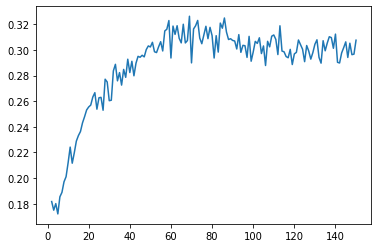

In [14]:
plt.plot(plot_x, s_avg)

## 結果
silhouette 和 Elbow 的結果好像差不多，到了 6,70 才開始趨緩

可能的解釋是此資料集的使用者無法做一個較好的分群

In [15]:
'''
# rename category
train = train_old.rename(columns={'Category 1': 'churches','Category 2': 'resorts','Category 3': 'beaches',
                                'Category 4': 'parks','Category 5': 'theatres','Category 6': 'museums',
                                'Category 7': 'malls','Category 8': 'zoo','Category 9': 'restaurants',
                                'Category 10': 'pubs/bars','Category 11': 'local services','Category 12': 'burger/pizza shops',
                                'Category 13': 'hotels/other lodgings','Category 14': 'juice bars','Category 15': 'art galleries',
                                'Category 16': 'dance clubs','Category 17': 'swimming pools','Category 18': 'gyms',
                                'Category 19': 'bakeries','Category 20': 'beauty & spas','Category 21': 'cafes',
                                'Category 22': 'view points','Category 23': 'monuments','Category 24': 'gardens',})

'''

"\n# rename category\ntrain = train_old.rename(columns={'Category 1': 'churches','Category 2': 'resorts','Category 3': 'beaches',\n                                'Category 4': 'parks','Category 5': 'theatres','Category 6': 'museums',\n                                'Category 7': 'malls','Category 8': 'zoo','Category 9': 'restaurants',\n                                'Category 10': 'pubs/bars','Category 11': 'local services','Category 12': 'burger/pizza shops',\n                                'Category 13': 'hotels/other lodgings','Category 14': 'juice bars','Category 15': 'art galleries',\n                                'Category 16': 'dance clubs','Category 17': 'swimming pools','Category 18': 'gyms',\n                                'Category 19': 'bakeries','Category 20': 'beauty & spas','Category 21': 'cafes',\n                                'Category 22': 'view points','Category 23': 'monuments','Category 24': 'gardens',})\n\n"

In [16]:
EXECUTION_END_TIME = time.time() # 計算執行時間
print('total execution time: {}'.format(EXECUTION_END_TIME - EXECUTION_START_TIME))

total execution time: 557.3453714847565
